# JDOT with MC simulation

In [1]:
import sys
sys.path.insert(0, '../')

import torch
import numpy as np
import matplotlib.pyplot as plt
import ot
import ot.plot
import ROOT
from ROOT import TFile, vector
from lib.model import DeepJDOT, RnnModel, DnnModel, ModelTrainer, DeepSemiJDOT
from lib.utility import *
from sklearn.manifold import TSNE
from lib.dataset import WaveformSliceDataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import random
from functools import partial
from tqdm import tqdm

2023-11-29 14:29:15.152316: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 14:29:15.152489: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 14:29:15.152601: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 14:29:15.164641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 14:29:21.787112: W tensorflow/compiler/

Welcome to JupyROOT 6.24/06


## Some functions

In [68]:
def plot(wf, markers=None, ax=None):
    ax.set_xlim((0, 1000))
    ax.step(range(wf.size()), wf)

    if markers is not None:
        x_sig = []
        y_sig = []
        x_bkg = []
        y_bkg = []
        for (x, y, tag) in markers:
            if tag == 0:
                x_bkg.append(x)
                y_bkg.append(y)
            elif tag == 1:
                x_sig.append(x)
                y_sig.append(y)
            else:
                pass
        ax.plot(x_sig, y_sig, 'or', label='Signal Candidates')
        ax.plot(x_bkg, y_bkg, '^b', label='Background Candidates')
        ax.legend()

def show_waveform(file, dataset=None, ax=None): 
    f = ROOT.TFile(file)
    t = f.Get('sim')

    wf = ROOT.std.vector['double'](0)
    t.SetBranchAddress('wf_i', wf)

    for i in range(1):
        t.GetEntry(i)

        markers = None
        if dataset is not None:
            markers = []
            evtno_dict = dataset.GetEventNoToIndexDict()
            for j in evtno_dict[0]:
                x = dataset.GetWaveformSliceTime(j)
                y = wf[int(x)]
                _, tag = dataset[j]
                tag = tag.numpy()
                markers.append((x, y, tag))

        plot(wf, markers, ax)

def show_waveform_semi(file, tree, irange=(0, 1), dataset=None, sign=1, aux=False, with_tag=True): 
    def plot(wf, markers=None, truths=None):
        plt.figure(figsize=(12, 6))
        plt.xlim((0, 500))
        plt.step(range(len(wf)), wf)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.xlabel('Time (index)', fontsize=26)
        plt.ylabel('Amplitude (a.u.)', fontsize=26)

        if markers is not None:
            x_sig = []
            y_sig = []
            x_bkg = []
            y_bkg = []
            for (x, y, tag) in markers:
                if tag == 0:
                    x_bkg.append(x)
                    y_bkg.append(y)
                elif tag == 1:
                    x_sig.append(x)
                    y_sig.append(y)
                else:
                    pass
            plt.plot(x_sig, y_sig, 'or', label='Signal Candidates', markersize=12)
            plt.plot(x_bkg, y_bkg, '^b', label='Noise Candidates', markersize=12)
        
        if truths is not None:
            truths_y = [wf[int(t)] for t in truths]
            plt.vlines(truths, 0, truths_y, colors='orange', label='MC Truth Times')
        
        plt.legend(fontsize=22)
        # plt.subplots_adjust(bottom=0.2)
        plt.savefig('mc_wf.eps')

    f = TFile(file)
    t = f.Get(tree)

    wf = vector['double'](0)
    time = vector['double'](0)
    tag = vector['int'](0)
    t.SetBranchAddress('wf_i', wf)
    if with_tag:
        t.SetBranchAddress('time', time)
        t.SetBranchAddress('tag', tag)

    for i in range(irange[0], irange[1]):
        t.GetEntry(i)

        if sign < 0:
            for iwf in range(wf.size()):
                wf[iwf] *= -1

        markers = None
        if dataset is not None:
            markers = []
            evtno_dict = dataset.GetEventNoToIndexDict()
            for j in evtno_dict[i]:
                x = dataset.GetWaveformSliceTime(j)
                y = wf[int(x)]
                if aux is False:
                    _tag = dataset.tag_list[j]
                else:
                    _tag = dataset.aux_tag_list[j]
                # tag = tag.numpy().item()
                markers.append((x, y, _tag))

        truths = None
        if with_tag:
            truths = [time[i] for i, t in enumerate(tag) if tag[i] > 0]

        # correct markers
        markers_corr = []
        for _m in markers:
            min_dt = 999.
            min_t = 999.
            if _m[2] == 1:
                for _t in truths:
                    mt = _m[0]
                    dt = np.abs(mt - _t)
                    if dt < min_dt:
                        min_dt = dt
                        min_t = _t
                markers_corr.append((min_t, wf[int(min_t)], _m[2]))
            else:
                markers_corr.append(_m)
        markers = markers_corr


        plot(wf, markers, truths)

## Datasets

In [7]:
semi_method = partial(semi_tag_method, widths=np.arange(1, 10, 0.2), min_snr=0.3)
check_source_dataset = WaveformSliceDataset('../dataset/source.root', 'sim', 0, 20, nleft=5, nright=9, with_tag=True, tag_method='default', aux_tag_method=semi_method)


Creating dataset: 100%|██████████| 20/20 [00:05<00:00,  3.48it/s]

[WaveformSliceDataset] : Total # of waveform slices = 29956
[WaveformSliceDataset] : Dataset has a size of (15,)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


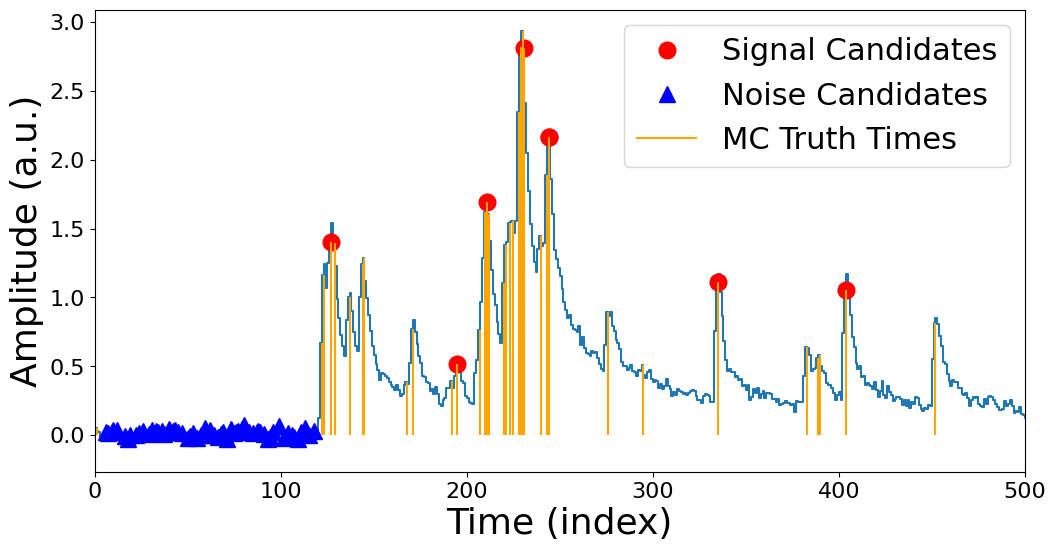

In [69]:
show_waveform_semi('../dataset/source.root', 'sim', irange=(15, 16), dataset=check_source_dataset, aux=True)

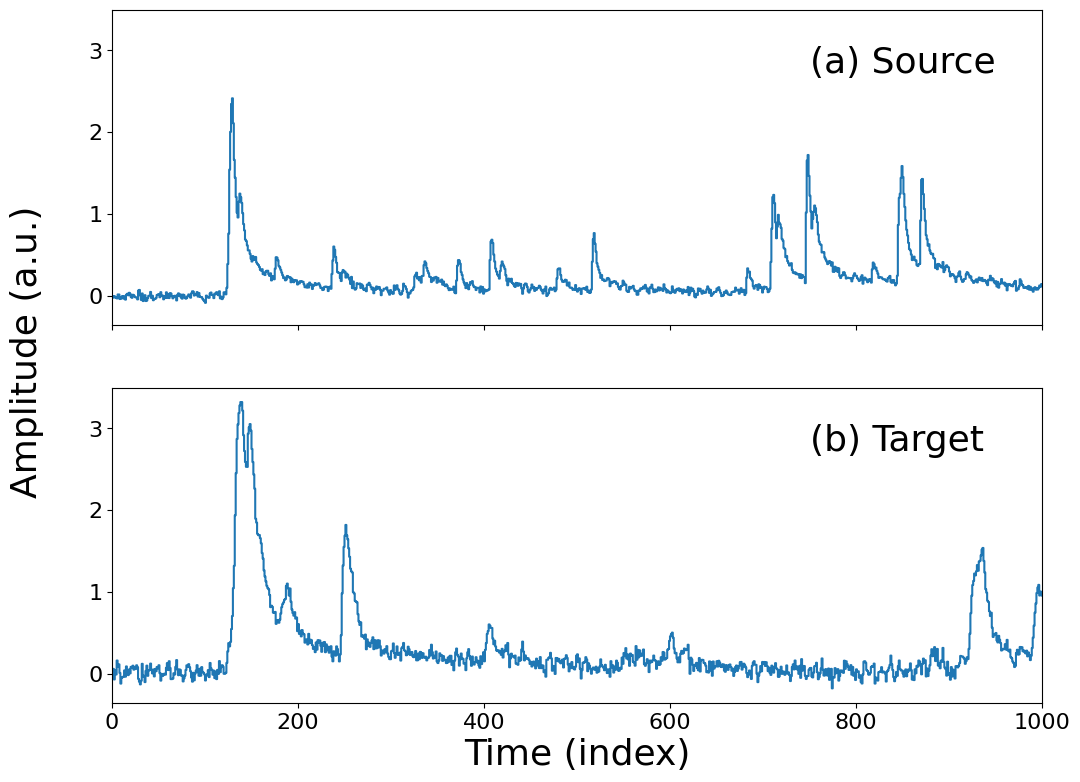

In [91]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12, 9))
show_waveform('../dataset/source.root', ax=ax[0])
show_waveform('../dataset/target.root', ax=ax[1])
ax[0].text(0.75, 0.8, '(a) Source', transform=ax[0].transAxes, fontsize=26)
ax[0].tick_params(labelsize=16)
ax[1].text(0.75, 0.8, '(b) Target', transform=ax[1].transAxes, fontsize=26)
ax[1].tick_params(labelsize=16)
# ax[0].set_ylabel('Amplitude (a.u.)', fontsize=16)
ax[1].set_xlabel('Time (index)', fontsize=26)
fig.text(0.04, 0.5, 'Amplitude (a.u.)', va='center', rotation='vertical', fontsize=26)
plt.savefig('sample.eps')

In [92]:
source_file = '../dataset/source.root'
target_file = '../dataset/target.root'
test_file = '../dataset/source_test.root'
num_train = 1000
num_test = 200
batch_size = 1024

source_dataset = WaveformSliceDataset(source_file, 'sim', 0, num_train, nleft=5, nright=9)
target_dataset = WaveformSliceDataset(target_file, 'sim', 0, num_train, nleft=5, nright=9, sign=1)
test_dataset = WaveformSliceDataset(test_file, 'sim', 0, num_test, nleft=5, nright=9)
torch.save(source_dataset, '../dataset/mc_source_dataset.pt')
torch.save(target_dataset, '../dataset/mc_target_dataset.pt')
torch.save(test_dataset, '../dataset/mc_test_dataset.pt')
source_dataset = torch.load('../dataset/mc_source_dataset.pt') 
target_dataset = torch.load('../dataset/mc_target_dataset.pt') 
test_dataset   = torch.load('../dataset/mc_test_dataset.pt') 
source_dataloader = DataLoader(source_dataset, batch_size=batch_size, shuffle=False, drop_last=True, sampler=balanced_sampler(source_dataset))
target_dataloader = DataLoader(target_dataset, batch_size=batch_size, shuffle=False, drop_last=True, sampler=balanced_sampler(target_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, sampler=balanced_sampler(test_dataset))

Creating dataset: 100%|██████████| 1000/1000 [01:16<00:00, 13.08it/s]


[WaveformSliceDataset] : Total # of waveform slices = 1496309
[WaveformSliceDataset] : Dataset has a size of (15,)


Creating dataset: 100%|██████████| 1000/1000 [01:54<00:00,  8.74it/s]


[WaveformSliceDataset] : Total # of waveform slices = 1493214
[WaveformSliceDataset] : Dataset has a size of (15,)


Creating dataset: 100%|██████████| 200/200 [00:24<00:00,  8.05it/s]


[WaveformSliceDataset] : Total # of waveform slices = 298830
[WaveformSliceDataset] : Dataset has a size of (15,)
number of balanced (sig, bkg) = (36879, 36879)
number of balanced (sig, bkg) = (33877, 33877)
number of balanced (sig, bkg) = (7200, 7200)


## Target model on target domain (fully supervised)

In [93]:
## RNN

model = RnnModel(embedding=False)
rnn_model = ModelTrainer(model)
rnn_model.fit(target_dataloader, target_dataloader, epoch_size=30, lr=1e-2)
rnn_model.evaluate(target_dataloader)
rnn_model.save('../results/rnn.pth')

Epoch 0:  Train Loss: 0.478, Train Acc: 0.774
          Val   Loss: 0.404, Val   Acc: 0.825
Epoch 1:  Train Loss: 0.399, Train Acc: 0.827
          Val   Loss: 0.385, Val   Acc: 0.834
Epoch 2:  Train Loss: 0.387, Train Acc: 0.834
          Val   Loss: 0.384, Val   Acc: 0.836
Epoch 3:  Train Loss: 0.379, Train Acc: 0.838
          Val   Loss: 0.387, Val   Acc: 0.832
Epoch 4:  Train Loss: 0.383, Train Acc: 0.836
          Val   Loss: 0.377, Val   Acc: 0.839
Epoch 5:  Train Loss: 0.379, Train Acc: 0.838
          Val   Loss: 0.379, Val   Acc: 0.838
Epoch 6:  Train Loss: 0.377, Train Acc: 0.839
          Val   Loss: 0.371, Val   Acc: 0.841
Epoch 7:  Train Loss: 0.375, Train Acc: 0.840
          Val   Loss: 0.374, Val   Acc: 0.840
Epoch 8:  Train Loss: 0.373, Train Acc: 0.841
          Val   Loss: 0.371, Val   Acc: 0.842
Epoch 9:  Train Loss: 0.375, Train Acc: 0.840
          Val   Loss: 0.372, Val   Acc: 0.841
Epoch 10:  Train Loss: 0.372, Train Acc: 0.841
          Val   Loss: 0.370, Val 

## Source model on target domain (without DA)

In [94]:

model = DnnModel(embedding=False)
jdot = DeepJDOT(model, init_lr=1e-3, verbose=1, ot_enable=False)
jdot.fit(source_dataloader=source_dataloader, target_dataloader=target_dataloader, test_dataloader=test_dataloader, epoch_size=50)
jdot.evaluate(target_dataloader)
jdot.save('../results/mc_no_ot.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

  Epoch 0: loss = [0.4885255], acc = 0.802734375


  2%|▏         | 1/50 [00:04<03:54,  4.78s/it]

          val. loss = 0.3815292183841978, val. acc = 0.8358677455357143
  Epoch 1: loss = [0.34014437], acc = 0.8586351799242424


  4%|▍         | 2/50 [00:13<05:27,  6.83s/it]

          val. loss = 0.30435940623283386, val. acc = 0.8791852678571429
  Epoch 2: loss = [0.2871158], acc = 0.8878432765151515


  6%|▌         | 3/50 [00:17<04:37,  5.91s/it]

          val. loss = 0.27272947132587433, val. acc = 0.8921595982142857
  Epoch 3: loss = [0.26583245], acc = 0.8939245975378788


  8%|▊         | 4/50 [00:22<04:07,  5.38s/it]

          val. loss = 0.25790717559201376, val. acc = 0.8967633928571429
  Epoch 4: loss = [0.25206345], acc = 0.8990589488636364


 10%|█         | 5/50 [00:26<03:42,  4.95s/it]

          val. loss = 0.24856716181550706, val. acc = 0.9001116071428571
  Epoch 5: loss = [0.24506101], acc = 0.9012932054924242


 12%|█▏        | 6/50 [00:30<03:22,  4.60s/it]

          val. loss = 0.24144388628857477, val. acc = 0.9025530133928571
  Epoch 6: loss = [0.23831438], acc = 0.9031723484848485


 14%|█▍        | 7/50 [00:34<03:13,  4.51s/it]

          val. loss = 0.2364786724959101, val. acc = 0.9045758928571429
  Epoch 7: loss = [0.23343185], acc = 0.9043856534090909


 16%|█▌        | 8/50 [00:39<03:04,  4.40s/it]

          val. loss = 0.23224482046706335, val. acc = 0.9064592633928571
  Epoch 8: loss = [0.22934781], acc = 0.9057469223484849


 18%|█▊        | 9/50 [00:42<02:53,  4.22s/it]

          val. loss = 0.2301960683294705, val. acc = 0.90625
  Epoch 9: loss = [0.22726092], acc = 0.9067678740530303


 20%|██        | 10/50 [00:47<02:48,  4.21s/it]

          val. loss = 0.22679378730910166, val. acc = 0.9076450892857143
  Epoch 10: loss = [0.22604917], acc = 0.9070490056818182


 22%|██▏       | 11/50 [00:51<02:43,  4.18s/it]

          val. loss = 0.2251777829868453, val. acc = 0.9100864955357143
  Epoch 11: loss = [0.22259666], acc = 0.9090021306818182


 24%|██▍       | 12/50 [00:55<02:40,  4.22s/it]

          val. loss = 0.22538782336882182, val. acc = 0.9093191964285714
  Epoch 12: loss = [0.22220425], acc = 0.9091944839015151


 26%|██▌       | 13/50 [00:59<02:36,  4.22s/it]

          val. loss = 0.22313262522220612, val. acc = 0.9098772321428571
  Epoch 13: loss = [0.21887653], acc = 0.9105557528409091


 28%|██▊       | 14/50 [01:03<02:32,  4.24s/it]

          val. loss = 0.2219496646097728, val. acc = 0.9105747767857143
  Epoch 14: loss = [0.21866867], acc = 0.9102006392045454


 30%|███       | 15/50 [01:08<02:28,  4.23s/it]

          val. loss = 0.22189069539308548, val. acc = 0.9105050223214286
  Epoch 15: loss = [0.21789269], acc = 0.9115323153409091


 32%|███▏      | 16/50 [01:12<02:21,  4.16s/it]

          val. loss = 0.2217159111584936, val. acc = 0.9108537946428571
  Epoch 16: loss = [0.21602759], acc = 0.9115471117424242


 34%|███▍      | 17/50 [01:16<02:17,  4.17s/it]

          val. loss = 0.2197040691971779, val. acc = 0.9122488839285714
  Epoch 17: loss = [0.21769783], acc = 0.9115175189393939


 36%|███▌      | 18/50 [01:20<02:13,  4.18s/it]

          val. loss = 0.2203261660678046, val. acc = 0.9124581473214286
  Epoch 18: loss = [0.21561134], acc = 0.9124496922348485


 38%|███▊      | 19/50 [01:24<02:07,  4.11s/it]

          val. loss = 0.21907727207456315, val. acc = 0.9120396205357143
  Epoch 19: loss = [0.21508908], acc = 0.9128639914772727


 40%|████      | 20/50 [01:28<02:03,  4.11s/it]

          val. loss = 0.21842891829354422, val. acc = 0.9137137276785714
  Epoch 20: loss = [0.21384954], acc = 0.9132339015151515


 42%|████▏     | 21/50 [01:32<01:58,  4.10s/it]

          val. loss = 0.2184151421700205, val. acc = 0.9128766741071429
  Epoch 21: loss = [0.21487938], acc = 0.9136482007575758


 44%|████▍     | 22/50 [01:36<01:55,  4.11s/it]

          val. loss = 0.2174571007490158, val. acc = 0.9127371651785714
  Epoch 22: loss = [0.21398492], acc = 0.9134706439393939


 46%|████▌     | 23/50 [01:40<01:48,  4.03s/it]

          val. loss = 0.21797358138220652, val. acc = 0.9135044642857143
  Epoch 23: loss = [0.21304528], acc = 0.9146099668560606


 48%|████▊     | 24/50 [01:44<01:45,  4.07s/it]

          val. loss = 0.21683361274855478, val. acc = 0.9140625
  Epoch 24: loss = [0.2130188], acc = 0.9145803740530303


 50%|█████     | 25/50 [01:49<01:42,  4.10s/it]

          val. loss = 0.21677994515214646, val. acc = 0.9139229910714286
  Epoch 25: loss = [0.21211646], acc = 0.9150686553030303


 52%|█████▏    | 26/50 [01:52<01:36,  4.04s/it]

          val. loss = 0.21713442248957499, val. acc = 0.9158761160714286
  Epoch 26: loss = [0.21136771], acc = 0.915231415719697


 54%|█████▍    | 27/50 [01:57<01:33,  4.07s/it]

          val. loss = 0.21610443719795772, val. acc = 0.9138532366071429
  Epoch 27: loss = [0.21113428], acc = 0.9164003314393939


 56%|█████▌    | 28/50 [02:01<01:32,  4.22s/it]

          val. loss = 0.2156090693814414, val. acc = 0.9147600446428571
  Epoch 28: loss = [0.21112256], acc = 0.915719696969697


 58%|█████▊    | 29/50 [02:05<01:28,  4.21s/it]

          val. loss = 0.21542738590921676, val. acc = 0.9163643973214286
  Epoch 29: loss = [0.20997167], acc = 0.9164003314393939


 60%|██████    | 30/50 [02:09<01:21,  4.09s/it]

          val. loss = 0.214822775551251, val. acc = 0.91650390625
  Epoch 30: loss = [0.21029322], acc = 0.9161339962121212


 62%|██████▏   | 31/50 [02:13<01:18,  4.11s/it]

          val. loss = 0.2146018413560731, val. acc = 0.9180385044642857
  Epoch 31: loss = [0.20913531], acc = 0.917288115530303


 64%|██████▍   | 32/50 [02:17<01:14,  4.14s/it]

          val. loss = 0.2145249226263591, val. acc = 0.9172712053571429
  Epoch 32: loss = [0.20718148], acc = 0.9181906960227273


 66%|██████▌   | 33/50 [02:21<01:09,  4.10s/it]

          val. loss = 0.2149993149297578, val. acc = 0.9171316964285714
  Epoch 33: loss = [0.20821898], acc = 0.9182202888257576


 68%|██████▊   | 34/50 [02:26<01:05,  4.12s/it]

          val. loss = 0.2146994418331555, val. acc = 0.9190150669642857
  Epoch 34: loss = [0.20896839], acc = 0.9179835464015151


 70%|███████   | 35/50 [02:30<01:02,  4.14s/it]

          val. loss = 0.2135565153190068, val. acc = 0.9167829241071429
  Epoch 35: loss = [0.20727605], acc = 0.9183386600378788


 72%|███████▏  | 36/50 [02:34<00:56,  4.07s/it]

          val. loss = 0.2133505301816123, val. acc = 0.9178989955357143
  Epoch 36: loss = [0.20702128], acc = 0.9183090672348485


 74%|███████▍  | 37/50 [02:38<00:53,  4.11s/it]

          val. loss = 0.21388294654233114, val. acc = 0.9174107142857143
  Epoch 37: loss = [0.20643987], acc = 0.9189749053030303


 76%|███████▌  | 38/50 [02:42<00:49,  4.11s/it]

          val. loss = 0.21298370510339737, val. acc = 0.9178292410714286
  Epoch 38: loss = [0.2077437], acc = 0.9184718276515151


 78%|███████▊  | 39/50 [02:46<00:45,  4.14s/it]

          val. loss = 0.2124050185084343, val. acc = 0.9187360491071429
  Epoch 39: loss = [0.20669241], acc = 0.9194779829545454


 80%|████████  | 40/50 [02:50<00:40,  4.06s/it]

          val. loss = 0.21316036794866836, val. acc = 0.9204799107142857
  Epoch 40: loss = [0.20522426], acc = 0.9196999289772727


 82%|████████▏ | 41/50 [02:54<00:36,  4.09s/it]

          val. loss = 0.21286987513303757, val. acc = 0.9195731026785714
  Epoch 41: loss = [0.20560578], acc = 0.9198774857954546


 84%|████████▍ | 42/50 [02:59<00:33,  4.18s/it]

          val. loss = 0.21154463504041945, val. acc = 0.9196428571428571
  Epoch 42: loss = [0.20391464], acc = 0.9201438210227273


 86%|████████▌ | 43/50 [03:03<00:28,  4.12s/it]

          val. loss = 0.21214639182601655, val. acc = 0.9189453125
  Epoch 43: loss = [0.2052478], acc = 0.9204397490530303


 88%|████████▊ | 44/50 [03:07<00:24,  4.14s/it]

          val. loss = 0.21152533910104207, val. acc = 0.9183175223214286
  Epoch 44: loss = [0.20426738], acc = 0.9201882102272727


 90%|█████████ | 45/50 [03:11<00:20,  4.14s/it]

          val. loss = 0.2117182399545397, val. acc = 0.9185965401785714
  Epoch 45: loss = [0.20442323], acc = 0.9200994318181818


 92%|█████████▏| 46/50 [03:15<00:16,  4.08s/it]

          val. loss = 0.2115234328167779, val. acc = 0.92041015625
  Epoch 46: loss = [0.20447691], acc = 0.9206616950757576


 94%|█████████▍| 47/50 [03:19<00:12,  4.10s/it]

          val. loss = 0.2114568395274026, val. acc = 0.9181780133928571
  Epoch 47: loss = [0.2042838], acc = 0.9208244554924242


 96%|█████████▌| 48/50 [03:23<00:08,  4.13s/it]

          val. loss = 0.21002405881881714, val. acc = 0.9190150669642857
  Epoch 48: loss = [0.20377813], acc = 0.921090790719697


 98%|█████████▊| 49/50 [03:27<00:04,  4.13s/it]

          val. loss = 0.2101514275584902, val. acc = 0.9206194196428571
  Epoch 49: loss = [0.20401308], acc = 0.9211795691287878


100%|██████████| 50/50 [03:31<00:00,  4.24s/it]

          val. loss = 0.21000515243836812, val. acc = 0.9202008928571429


Test acc. = 0.8035038113594055


## Source model on target domain (with DA)

In [95]:
model = DnnModel(embedding=True)
jdot = DeepJDOT(model, init_lr=1e-3, verbose=1, ot_enable=True, alpha=0.01, ot_method='emd', lambda_s=1.0)
jdot.fit(source_dataloader=source_dataloader, target_dataloader=target_dataloader, test_dataloader=test_dataloader, epoch_size=30, verbose=0)
jdot.evaluate(dataloader=target_dataloader)
jdot.save('../results/mc_ot.pth')

  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 0: loss = 0.7157810212987842, acc = 0.852346709280303


  3%|▎         | 1/30 [00:15<07:27, 15.42s/it]

          val. loss = 0.27713977971247267, val. acc = 0.8837890625
  Epoch 1: loss = 0.5235001056483297, acc = 0.8924745501893939


  7%|▋         | 2/30 [00:30<07:04, 15.16s/it]

          val. loss = 0.24507647646324976, val. acc = 0.8976004464285714
  Epoch 2: loss = 0.48801274010629364, acc = 0.8997839725378788


 10%|█         | 3/30 [00:45<06:46, 15.04s/it]

          val. loss = 0.24187573684113367, val. acc = 0.89892578125
  Epoch 3: loss = 0.4807686679291003, acc = 0.9017370975378788


 13%|█▎        | 4/30 [01:00<06:31, 15.08s/it]

          val. loss = 0.2440776995250157, val. acc = 0.8957170758928571
  Epoch 4: loss = 0.465692450151299, acc = 0.9058652935606061


 17%|█▋        | 5/30 [01:15<06:17, 15.11s/it]

          val. loss = 0.23265943569796427, val. acc = 0.9047154017857143
  Epoch 5: loss = 0.4582994526082819, acc = 0.9081143465909091


 20%|██        | 6/30 [01:30<06:01, 15.05s/it]

          val. loss = 0.2262016630598477, val. acc = 0.9114815848214286
  Epoch 6: loss = 0.4586334142721061, acc = 0.9085878314393939


 23%|██▎       | 7/30 [01:45<05:46, 15.07s/it]

          val. loss = 0.22620362043380737, val. acc = 0.9078543526785714
  Epoch 7: loss = 0.4554444799820582, acc = 0.9087505918560606


 27%|██▋       | 8/30 [02:00<05:32, 15.13s/it]

          val. loss = 0.2244573895420347, val. acc = 0.9091099330357143
  Epoch 8: loss = 0.44828871073144855, acc = 0.9103633996212122


 30%|███       | 9/30 [02:15<05:15, 15.00s/it]

          val. loss = 0.2157777366893632, val. acc = 0.9149693080357143
  Epoch 9: loss = 0.4465707910783363, acc = 0.9115027225378788


 33%|███▎      | 10/30 [02:31<05:02, 15.13s/it]

          val. loss = 0.22766664517777307, val. acc = 0.9099469866071429
  Epoch 10: loss = 0.43942788469068933, acc = 0.9128343986742424


 37%|███▋      | 11/30 [02:46<04:46, 15.09s/it]

          val. loss = 0.22497463439192092, val. acc = 0.9117606026785714
  Epoch 11: loss = 0.4535624904162956, acc = 0.9097419507575758


 40%|████      | 12/30 [03:01<04:34, 15.28s/it]

          val. loss = 0.2262633964419365, val. acc = 0.9090401785714286
  Epoch 12: loss = 0.43984000384807587, acc = 0.9133226799242424


 43%|████▎     | 13/30 [03:16<04:18, 15.22s/it]

          val. loss = 0.21317917108535767, val. acc = 0.9164341517857143
  Epoch 13: loss = 0.44039571646488074, acc = 0.9123757102272727


 47%|████▋     | 14/30 [03:32<04:03, 15.24s/it]

          val. loss = 0.22016555496624537, val. acc = 0.9139927455357143
  Epoch 14: loss = 0.4359258724884553, acc = 0.9151722301136364


 50%|█████     | 15/30 [03:47<03:47, 15.17s/it]

          val. loss = 0.22780199561800277, val. acc = 0.9079241071428571
  Epoch 15: loss = 0.43044386849258887, acc = 0.9161487926136364


 53%|█████▎    | 16/30 [04:02<03:31, 15.10s/it]

          val. loss = 0.22508137779576437, val. acc = 0.9108537946428571
  Epoch 16: loss = 0.43221405600056506, acc = 0.9141660748106061


 57%|█████▋    | 17/30 [04:17<03:16, 15.09s/it]

          val. loss = 0.21642622458083288, val. acc = 0.9138532366071429
  Epoch 17: loss = 0.4318256283348257, acc = 0.9151426373106061


 60%|██████    | 18/30 [04:32<03:02, 15.23s/it]

          val. loss = 0.23140894728047506, val. acc = 0.9053431919642857
  Epoch 18: loss = 0.4337081719528545, acc = 0.9143732244318182


 63%|██████▎   | 19/30 [04:47<02:47, 15.18s/it]

          val. loss = 0.21180526273591177, val. acc = 0.91552734375
  Epoch 19: loss = 0.4290603498617808, acc = 0.9139589251893939


 67%|██████▋   | 20/30 [05:02<02:30, 15.07s/it]

          val. loss = 0.21961973288229533, val. acc = 0.9117606026785714
  Epoch 20: loss = 0.42533869996215357, acc = 0.9159564393939394


 70%|███████   | 21/30 [05:17<02:15, 15.05s/it]

          val. loss = 0.22064630900110518, val. acc = 0.91259765625
  Epoch 21: loss = 0.42452724277973175, acc = 0.916696259469697


 73%|███████▎  | 22/30 [05:33<02:01, 15.18s/it]

          val. loss = 0.21050140580960683, val. acc = 0.9177594866071429
  Epoch 22: loss = 0.4247598575823235, acc = 0.9176580255681818


 77%|███████▋  | 23/30 [05:48<01:46, 15.15s/it]

          val. loss = 0.21435786251510894, val. acc = 0.916015625
  Epoch 23: loss = 0.42600964551622217, acc = 0.9167406486742424


 80%|████████  | 24/30 [06:03<01:31, 15.21s/it]

          val. loss = 0.20692158383982523, val. acc = 0.9185965401785714
  Epoch 24: loss = 0.420383351318764, acc = 0.9183830492424242


 83%|████████▎ | 25/30 [06:18<01:15, 15.16s/it]

          val. loss = 0.21242236239569529, val. acc = 0.9161551339285714
  Epoch 25: loss = 0.4177503694187511, acc = 0.9183682528409091


 87%|████████▋ | 26/30 [06:34<01:01, 15.28s/it]

          val. loss = 0.2109649074929101, val. acc = 0.9163643973214286
  Epoch 26: loss = 0.41644796548467694, acc = 0.9191672585227273


 90%|█████████ | 27/30 [06:49<00:45, 15.17s/it]

          val. loss = 0.21264629811048508, val. acc = 0.916015625
  Epoch 27: loss = 0.4184155495780887, acc = 0.9192708333333334


 93%|█████████▎| 28/30 [07:04<00:30, 15.13s/it]

          val. loss = 0.21160358722720826, val. acc = 0.9164341517857143
  Epoch 28: loss = 0.4167928420233004, acc = 0.9197147253787878


 97%|█████████▋| 29/30 [07:19<00:15, 15.16s/it]

          val. loss = 0.20776998038802827, val. acc = 0.91845703125
  Epoch 29: loss = 0.42107939404068573, acc = 0.9171549479166666


100%|██████████| 30/30 [07:34<00:00, 15.15s/it]

          val. loss = 0.2066783287695476, val. acc = 0.9173409598214286


Test acc. = 0.8249141573905945


## Source model on target domain (with DA and semi-supervised)

In [96]:
from lib.model import DeepSemiJDOT

model = DnnModel(embedding=True)
jdot = DeepSemiJDOT(model, init_lr=1e-3, verbose=1, ot_enable=True, alpha=0.01, ot_method='emd', lambda_s=1.0)
jdot.fit(source_dataloader=source_dataloader, target_dataloader=target_dataloader, test_dataloader=test_dataloader, epoch_size=30, verbose=0)
jdot.save('../results/mc_ot_semi.pth')

  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch 0: loss = 1.1818027351841782, acc = 0.8597892992424242, acc_l = 0.8052941524621212


  3%|▎         | 1/30 [00:16<07:53, 16.33s/it]

          val. loss = 0.2745995691844395, val. acc = 0.8915318080357143
  Epoch 1: loss = 0.9378053907192114, acc = 0.8902402935606061, acc_l = 0.8332445549242424


  7%|▋         | 2/30 [00:32<07:29, 16.06s/it]

          val. loss = 0.24811178978000367, val. acc = 0.8992047991071429
  Epoch 2: loss = 0.908133221395088, acc = 0.89599609375, acc_l = 0.8351976799242424


 10%|█         | 3/30 [00:47<07:08, 15.86s/it]

          val. loss = 0.2504420738135065, val. acc = 0.8994140625
  Epoch 3: loss = 0.9011501362829497, acc = 0.8970910274621212, acc_l = 0.8363961884469697


 13%|█▎        | 4/30 [01:03<06:54, 15.92s/it]

          val. loss = 0.25224327721766066, val. acc = 0.8939034598214286
  Epoch 4: loss = 0.8838515697103558, acc = 0.9014263731060606, acc_l = 0.8382309422348485


 17%|█▋        | 5/30 [01:20<06:41, 16.08s/it]

          val. loss = 0.2328308235321726, val. acc = 0.9052734375
  Epoch 5: loss = 0.8790294898278785, acc = 0.9023141571969697, acc_l = 0.839163115530303


 20%|██        | 6/30 [01:36<06:24, 16.02s/it]

          val. loss = 0.23640870409352438, val. acc = 0.90380859375
  Epoch 6: loss = 0.8764297348080259, acc = 0.903127959280303, acc_l = 0.8383197206439394


 23%|██▎       | 7/30 [01:52<06:11, 16.14s/it]

          val. loss = 0.245599131499018, val. acc = 0.8956473214285714
  Epoch 7: loss = 0.8731463479273247, acc = 0.904489228219697, acc_l = 0.8386452414772727


 27%|██▋       | 8/30 [02:08<05:54, 16.11s/it]

          val. loss = 0.24549829640558787, val. acc = 0.8966238839285714
  Epoch 8: loss = 0.8647190774932052, acc = 0.9069010416666666, acc_l = 0.8399029356060606


 30%|███       | 9/30 [02:24<05:37, 16.08s/it]

          val. loss = 0.2381185899887766, val. acc = 0.9001813616071429
  Epoch 9: loss = 0.8619045398452065, acc = 0.9072265625, acc_l = 0.8395034327651515


 33%|███▎      | 10/30 [02:40<05:19, 15.99s/it]

          val. loss = 0.22652178683451243, val. acc = 0.9091796875
  Epoch 10: loss = 0.8584246599312985, acc = 0.9085582386363636, acc_l = 0.8403616240530303


 37%|███▋      | 11/30 [02:56<05:05, 16.07s/it]

          val. loss = 0.23331493777888163, val. acc = 0.9061802455357143
  Epoch 11: loss = 0.8559506273630894, acc = 0.9089577414772727, acc_l = 0.8406871448863636


 40%|████      | 12/30 [03:12<04:49, 16.06s/it]

          val. loss = 0.22779267387730734, val. acc = 0.9081333705357143
  Epoch 12: loss = 0.8593324034503012, acc = 0.9089133522727273, acc_l = 0.8395626183712122


 43%|████▎     | 13/30 [03:28<04:33, 16.08s/it]

          val. loss = 0.23067509489400045, val. acc = 0.9063895089285714
  Epoch 13: loss = 0.8498631851239637, acc = 0.9111032196969697, acc_l = 0.8412790009469697


 47%|████▋     | 14/30 [03:44<04:15, 15.97s/it]

          val. loss = 0.24179055116006307, val. acc = 0.8987165178571429
  Epoch 14: loss = 0.8496904887936332, acc = 0.9103042140151515, acc_l = 0.8411014441287878


 50%|█████     | 15/30 [04:00<04:01, 16.11s/it]

          val. loss = 0.23170969635248184, val. acc = 0.9064592633928571
  Epoch 15: loss = 0.8449329426794341, acc = 0.9140772964015151, acc_l = 0.8413973721590909


 53%|█████▎    | 16/30 [04:16<03:45, 16.07s/it]

          val. loss = 0.2277709831084524, val. acc = 0.91064453125
  Epoch 16: loss = 0.844278605598392, acc = 0.9126716382575758, acc_l = 0.8412937973484849


 57%|█████▋    | 17/30 [04:32<03:27, 15.99s/it]

          val. loss = 0.21863943551267898, val. acc = 0.9148297991071429
  Epoch 17: loss = 0.8437460390004244, acc = 0.9130711410984849, acc_l = 0.8416785037878788


 60%|██████    | 18/30 [04:49<03:13, 16.11s/it]

          val. loss = 0.23274813273123332, val. acc = 0.9102957589285714
  Epoch 18: loss = 0.8417867702065092, acc = 0.9135002367424242, acc_l = 0.8422259706439394


 63%|██████▎   | 19/30 [05:05<02:57, 16.10s/it]

          val. loss = 0.2241012996860913, val. acc = 0.9115513392857143
  Epoch 19: loss = 0.8360823817325361, acc = 0.9141068892045454, acc_l = 0.8423443418560606


 67%|██████▋   | 20/30 [05:21<02:40, 16.08s/it]

          val. loss = 0.22234840158905303, val. acc = 0.9115513392857143
  Epoch 20: loss = 0.8373808860778809, acc = 0.9149798768939394, acc_l = 0.842477509469697


 70%|███████   | 21/30 [05:37<02:24, 16.02s/it]

          val. loss = 0.22322705068758555, val. acc = 0.9132254464285714
  Epoch 21: loss = 0.8428362942103184, acc = 0.9137369791666666, acc_l = 0.8418412642045454


 73%|███████▎  | 22/30 [05:53<02:08, 16.07s/it]

          val. loss = 0.22156499858413423, val. acc = 0.9134347098214286
  Epoch 22: loss = 0.832162885051785, acc = 0.9152018229166666, acc_l = 0.8431877367424242


 77%|███████▋  | 23/30 [06:09<01:52, 16.04s/it]

          val. loss = 0.2319764175585338, val. acc = 0.9070870535714286
  Epoch 23: loss = 0.8333942447647904, acc = 0.9157640861742424, acc_l = 0.8416637073863636


 80%|████████  | 24/30 [06:25<01:35, 15.98s/it]

          val. loss = 0.2246787931237902, val. acc = 0.91455078125
  Epoch 24: loss = 0.8348013370326071, acc = 0.914743134469697, acc_l = 0.842581084280303


 83%|████████▎ | 25/30 [06:41<01:20, 16.01s/it]

          val. loss = 0.24461775379521505, val. acc = 0.8991350446428571
  Epoch 25: loss = 0.8310563473990469, acc = 0.9151426373106061, acc_l = 0.8444602272727273


 87%|████████▋ | 26/30 [06:57<01:04, 16.13s/it]

          val. loss = 0.22296165994235448, val. acc = 0.9109235491071429
  Epoch 26: loss = 0.8278238529508765, acc = 0.9173177083333334, acc_l = 0.8443418560606061


 90%|█████████ | 27/30 [07:13<00:48, 16.11s/it]

          val. loss = 0.23360448437077658, val. acc = 0.9070870535714286
  Epoch 27: loss = 0.8287345640587084, acc = 0.9164891098484849, acc_l = 0.843942353219697


 93%|█████████▎| 28/30 [07:32<00:33, 16.84s/it]

          val. loss = 0.22891350516251155, val. acc = 0.91162109375
  Epoch 28: loss = 0.830511911348863, acc = 0.9168146306818182, acc_l = 0.8433948863636364


 97%|█████████▋| 29/30 [07:48<00:16, 16.67s/it]

          val. loss = 0.21788559428283147, val. acc = 0.91748046875
  Epoch 29: loss = 0.8273639001629569, acc = 0.9164299242424242, acc_l = 0.8446525804924242


100%|██████████| 30/30 [08:04<00:00, 16.15s/it]

          val. loss = 0.23057523369789124, val. acc = 0.9072265625


In [97]:
# test_dataset = WaveformSliceDataset('../dataset/target_test.root', 'sim', 0, 1000, nleft=5, nright=9, with_tag=True)
# torch.save(test_dataset, '../dataset/target_test_dataset.pt')
test_dataset=torch.load('../dataset/target_test_dataset.pt')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True, sampler=balanced_sampler(test_dataset))

number of balanced (sig, bkg) = (34338, 34338)


In [98]:
model_rnn = RnnModel(embedding=False)
model_rnn.load_state_dict(torch.load('../results/rnn.pth'))

model_no_ot = DnnModel(embedding=False)
model_no_ot.load_state_dict(torch.load('../results/mc_no_ot.pth'))

model_ot = DnnModel(embedding=True)
model_ot.load_state_dict(torch.load('../results/mc_ot.pth'))

model_ot_semi = DnnModel(embedding=True)
model_ot_semi.load_state_dict(torch.load('../results/mc_ot_semi.pth'))

<All keys matched successfully>

In [99]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def calc_roc_curve(model, dataset=test_dataset, n=1000000):
    y_list = []
    ypred_list = []
    for i in tqdm(range(n)):
        idx = random.randint(0, len(dataset)-1)
        X, y = dataset[idx]
        y_pred, _ = model(X)
        y = y.detach().numpy()
        y_pred = y_pred.detach().numpy()
        y_list.append(y)
        ypred_list.append(y_pred)

    fpr, tpr, thr = roc_curve(y_list, ypred_list)
    auc = roc_auc_score(y_list, ypred_list)
    auc_small = roc_auc_score(y_list, ypred_list, max_fpr=0.1)
    return fpr, tpr, thr, auc, auc_small


In [100]:
num=int(1E6)
fpr0, tpr0, thr0, auc0, auc0_small = calc_roc_curve(model_rnn, n=int(num/10))
fpr1, tpr1, thr1, auc1, auc1_small = calc_roc_curve(model_no_ot, n=num)
fpr2, tpr2, thr2, auc2, auc2_small = calc_roc_curve(model_ot, n=num)
fpr3, tpr3, thr3, auc3, auc3_small = calc_roc_curve(model_ot_semi, n=num)
roc_data = (fpr0, tpr0, fpr1, tpr1, fpr2, tpr2, fpr3, tpr3)
torch.save(roc_data, '../dataset/roc_data.pt')

100%|██████████| 1000000/1000000 [03:37<00:00, 4603.39it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0.8160681941341292
0.7573899473732868
0.77527275378196
0.8002769613329015


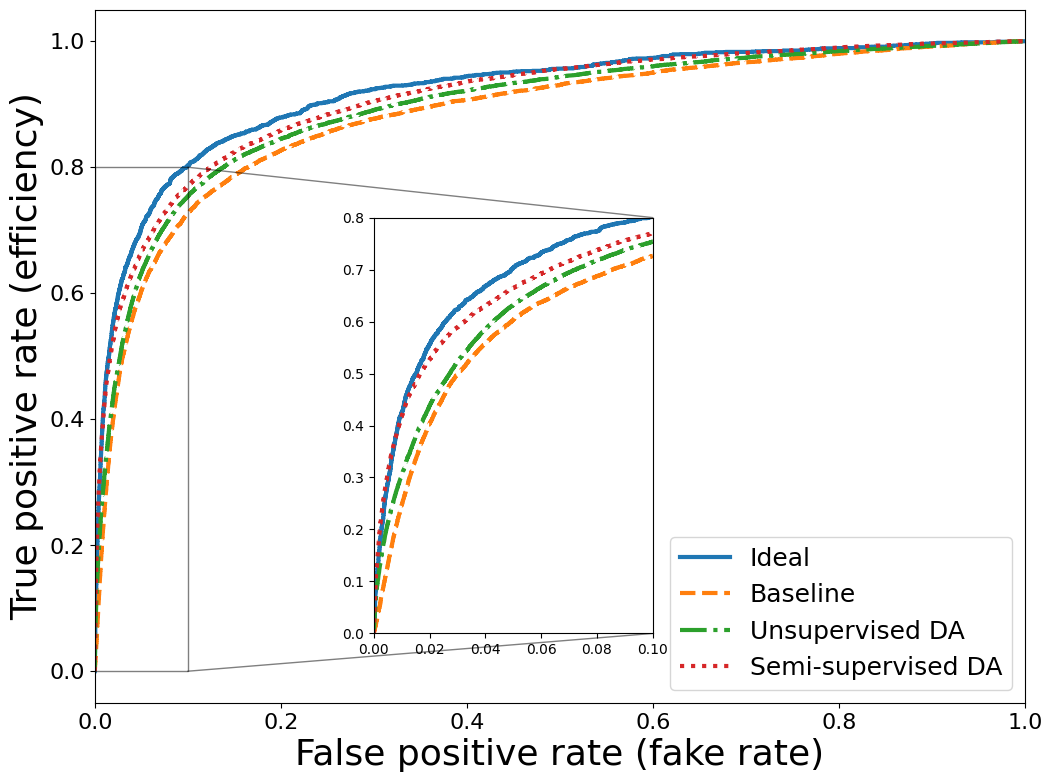

In [102]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(fpr0, tpr0, label='Ideal', lw=3)
ax.plot(fpr1, tpr1, label='Baseline', linestyle='--', lw=3)
ax.plot(fpr2, tpr2, label='Unsupervised DA', linestyle='-.', lw=3)
ax.plot(fpr3, tpr3, label='Semi-supervised DA', linestyle=':', lw=3)
ax.set_xlabel('False positive rate (fake rate)', fontsize=26)
ax.set_ylabel('True positive rate (efficiency)', fontsize=26)
# ax.set_title('ROC Curve', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xlim((0, 1))
ax.legend(fontsize=18)

axins = ax.inset_axes([0.3, 0.1, 0.3, 0.6])
axins.plot(fpr0, tpr0, lw=3)
axins.plot(fpr1, tpr1, linestyle='--', lw=3)
axins.plot(fpr2, tpr2, linestyle='-.', lw=3)
axins.plot(fpr3, tpr3, linestyle=':', lw=3)
x1, x2, y1, y2 = 0.0, 0.1, 0.0, 0.8
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins, edgecolor='black')

plt.savefig('roc.eps')


print(auc0_small)
print(auc1_small)
print(auc2_small)
print(auc3_small)

